We use an Actor-Critic style method on the `BipedalWalker-v2` task from the [*OpenAI gym* toolkit](https://gym.openai.com/envs/BipedalWalker-v2/), using basic TensorFlow. I improvised here and there for the specific problem. In particular, we use a **rollout estimator with a random horizon** to approximate TD($\lambda$) with a very simple and cheap implementation.

The task is to help a two-legged robot learn how to walk forward. Reward is given for moving forward, total 300+ points up to the far end. If the robot falls, it gets -100. Applying motor torque costs a small amount of points. It poses a combination of challenges: the robot not only needs to learn how to walk, but also to walk fast without falling, with as little action as possible, on a randomly generated terrain, and with continuous action parameters.

Here is the video for my final walker that solved the task:
[![Video of final Walker for BipedalWalker-v2](http://img.youtube.com/vi/WZ2lq4uzs1k/0.jpg)](http://www.youtube.com/watch?v=WZ2lq4uzs1k "Final walker for BipedalWalker-v2")


The state and action parameters can be found at [here](https://github.com/openai/gym/wiki/BipedalWalker-v2). Most of them are self-explanatory. The "10 lidar readings" refer to the terrain measurements made by that moving red laser. It actually updates every step, even though the red laser seems to scan only once in a while.

When terrain is more rugged, the partial information from lidar readings is not sufficient to learn a maneuver, and we need to use **LSTM** to provide historical data. For this task, since the terrain, despite being random, is relatively flat, we will only use the current data.

---

Installation of the box2d environment on windows(this took me a long time to figure out; unfortunately WSL does not support GPU):
* pybox2d has to be built from source to be compatible with Tensorflow
* To do that, first download `swig` compiled for windows, and add the directory to system `PATH`.
* Install Microsoft Visual C++ 14.0 and add the following specific folders to system `PATH`(maybe also `LIB` or `INCLUDE`):

`C:\Program Files (x86)\Microsoft Visual Studio 14.0\VC\bin\amd64`

`C:\Program Files (x86)\Microsoft Visual Studio 14.0\VC\lib\amd64`

---

There are many variations of the Actor-Critic model, in terms of both implementation as well as theoretical improvements. The specific implementation here is following my own preference and understanding. From my point of view, AC can be seen as a combination of policy gradient and TD or Q-learning. The actor network, which learns to choose the best action, tends to reduce bias but increase variance in the performance. The critic network, on the other hand, tends to decrease variance but bring bias by tring to learn the inherent long term value of a state-action pair. The fact that the two networks can get trained together is the most fascinating aspect for me.

One difficulty dealing with continuous action AC is that, since the actor merely outputs an action, it is not clear what the action distribution is. To train the actor properly by backprop, I decided to stick to that action, which makes the actor being trained deterministic. To encourage exploration, we will have to introduce randomness somewhere.

Therefore we will keep a separate copy of the actor, updated by the current actor once in a while. We shall call this actor the **explorer**. We generate a memory buffer using the explorer mixed with certain randomness. The randomness can be tuned down gradually to decrease exploration as time goes on. We train the actor and critic over minibatches from the replay memory. 

Another difficulty for this specific problem is that the environment does not support online rollout from a specific memory snapshot. It is technically not allowed to implement it, because the terrain for each replay is randomized, and in order to do an online rollout, we will have to know the specific position given the random seed of the terrain. But the problem is set up so that we should not use position coordinates. This limitation prohibits us from using some techniques based on online rollouts.

To reduce bias, we shall use a novel **rollout estimator with a random horizon** to train the critic network, where the minimum horizon length also decreases as training goes on. This is inspired by TD($\lambda$) learning and should achieve similar effect. But this implementation is much easier and cheaper compared to saving a trace. Experimentally, starting with longer horizons avoids early convergence to a bad local minimum. The intuitions are the following. Initially the movement is rather random and nonoptimal, so the reward over a short horizon is not that informative, and taking reward over a longer horizon smooths out the randomness. Also, a short horizon will force the critic network to converge locally, as the state does not change much over a short horizon. Over a longer horizon, the initial and final states and actions are rather different, so the critic network is converging in a more global fashion. However, at later stage of the training, we would like both networks to converge globally as well as locally, so we tune down the minimum horizon. Hopefully by that time, the network is already near a global optimum, and the randomness is also low, so even short time reward is close to an optimal action.

Furthermore, to avoid unstablity, we also keep a separate copy of the critic for the value estimator, and **partially update** it whenever we update the explorer. 

The hyperparameters here are definitely not optimal, as I am training on my laptop, which takes a few days. To be safe, I chose very conservative parameters(for example, the randomness is dropping very slowly, and training is done quite infrequently compared to the total trial episodes).

---

Let us import common packages and the `BipedalWalker-v2` environment.

Note that in Windows system, even if we render with `rgb_array` mode, it still tries to output the picture in a separate window. On Linux, one can run `Xvfb` to avoid it, but unfortunately it seems unavailable for Windows.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


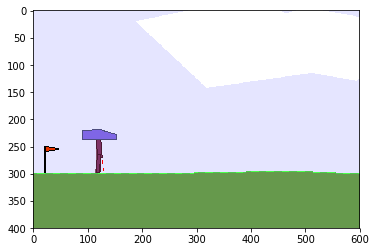

In [10]:
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
plt.ion()
from my_util import show_graph, reset_graph
import gym
env = gym.make('BipedalWalker-v2')
env.reset()
img = env.render(mode="rgb_array")
plt.imshow(img)
plt.show()
env.close()

First, we shall build the basic neural networks for the actor and critic. The structure is definitely not optimal, as I am using the same structure for both actor and critic. But since it takes a few days to train on my laptop, there is no point for me to look for the optimal structure and hyperparameter. In practice, the network structure seems definitely good enough. 

Since the action is between -1 and +1, we shall use `tanh` for the actor output.

In [2]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
n_hidden = [48, 48, 32]
he_init = tf.contrib.layers.variance_scaling_initializer()
tanh_init = tf.contrib.layers.variance_scaling_initializer(factor=16.0)

def actor(X_state, name, trainable = True):
    layer = X_state
    with tf.variable_scope(name) as scope:
        for i, units in enumerate(n_hidden):
            layer = tf.layers.dense(layer, units, activation=tf.nn.elu, name = f'hidden_{i}', kernel_initializer = he_init, trainable = trainable)
        layer = tf.layers.dense(layer, action_size, activation=tf.nn.tanh, name = 'output', kernel_initializer = tanh_init, trainable = trainable)
        
    net_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = scope.name)
    vars_by_name = {var.name[len(scope.name):] : var for var in net_vars}
    return layer, vars_by_name

def critic(X_state, X_action, name, trainable = True):
    layer = tf.concat([X_state, X_action], 1)
    with tf.variable_scope(name) as scope:
        for i, units in enumerate(n_hidden):
            layer = tf.layers.dense(layer, units, activation=tf.nn.elu, name = f'hidden_{i}', kernel_initializer = he_init, trainable = trainable)
        layer = tf.layers.dense(layer, 1, name = 'output', trainable = trainable)
        
    net_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = scope.name)
    vars_by_name = {var.name[len(scope.name):] : var for var in net_vars}
    return layer, vars_by_name

Now let us create the online and copy versions of the two networks as well as the ops for copying. The critic will be partially copied, so that the Q learning is more stable.

In [3]:
reset_graph()

X_state = tf.placeholder(tf.float32, shape = [None, state_size])
X_action = tf.placeholder(tf.float32, shape = [None, action_size])

actor_online, actor_online_vars = actor(X_state, name = "actor/online", trainable = True)
actor_copy, actor_copy_vars = actor(X_state, name = "actor/copy", trainable = False)

critic_online, critic_online_vars = critic(X_state, X_action, name = "critic/online", trainable = True)
critic_copy, critic_copy_vars = critic(X_state, X_action, name = "critic/copy", trainable = False)

def copy_ops(online_vars, copy_vars, ratio = 1.0):
    ratio = tf.constant(ratio, dtype = tf.float32)
    return [copy_var.assign(ratio * online_vars[var_name] + (1 - ratio) * copy_vars[var_name]) for var_name, copy_var in copy_vars.items()]

all_copy_ops = tf.group(*(copy_ops(actor_online_vars, actor_copy_vars, 1.0) + copy_ops(critic_online_vars, critic_copy_vars, 0.25)))

actor_trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = "actor/online")
critic_trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = "critic/online") 
    
#show_graph(tf.get_default_graph())
#tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
#tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

We shall use `deque` to store the memory buffer. For each playthrough, we choose a random `horizon`. Each entry will store a slice containing the current state, the action, the discounted total awards in the future `horizon` steps (or shorter if the game ends), and the state and action after `horizon` steps. 

We will not store the slices which ended by running out of time without falling, as they do not provide a final action. 

Since each game can take maximal 1600 steps, we might want to store only a subset of the longer games.

In later games, we want to store slices of falling instances to punish it more (the goal of the task requires not falling in 100 consecutive games). In early games, we want to encourage the walker to learn maneuvers, so we punish falling less.

One possibility of improvement for memorization is that, in later training, we only store slices which begin and end with nonrandom actions.(We cannot do that in early training because almost all actions are random by our design.) But that requires recording even more information for each step, and our final randomness is very low, so it seems not necessary in this setting.

Another possibility of improvement is to randomly switch the role of left and right legs, since they are completely symmetric in this task, and the networks initially tend to focus completely on one side of the symmetry. But I decided not to do that, because that seems to be taking advantage of too specific knowledge about this particular task and not generalizable.

In [ ]:
from collections import deque
import random

memory_size = 200000
memory = deque([], maxlen = memory_size)
discount_rate = 0.99
init_min_horizon = 50
fin_min_horizon = 1
horizon_length = 50
discount_array = [discount_rate ** i for i in range(init_min_horizon + horizon_length)]
max_store_per_game = 200
late = False
threshold = 200

def fill_memory(mem, play, min_horizon, horizon_length):
    horizon = random.randrange(round(min_horizon), round(min_horizon + horizon_length))
    max_discount = discount_array[horizon]
    tail = len(play) - 1
    head = len(play) - 1
    accu_reward = 0    
    next_action = env.action_space.sample()
    if not late and (tail >= 0):
        if play[tail][4] and (play[tail][2] < -10): 
            play[tail][2] = -50
    while head >= 0:
        if tail - head == horizon:
            accu_reward -= max_discount * play[tail][2]
        accu_reward = accu_reward * discount_rate + play[head][2]

        if tail < len(play) - 1:
            next_action = play[tail + 1][1]

        store = True
#If the game is too long, we store a random subset     
        if len(play) > max_store_per_game:
            if np.random.rand() > max_store_per_game / len(play):
                store = False
                
#In late training, we enforce the memorization of falling to solve the problem(100 consecutive 300+).               
        if late:
            if play[tail][4] and (play[tail][2] < -10): 
                store = True
                
#If the slice ends with a game termination, we do not store it if the game ends with timeout, since there is no next action. 
        if play[tail][4] and (play[tail][2] > -10): 
                store = False

# We store the current state, action, accumulated rewards in the future horizon, future state after horizon steps, next action at future state after horizon steps, flag whether game ended, the horizon length.      
        if store: mem.append((play[head][0], play[head][1], accu_reward, play[tail][3], next_action, play[tail][4], horizon))
        head -= 1
        if (tail - head > horizon):
            tail -= 1
    return          

We initialize the memory with completely random explorations, and save it to a pickle to speed up later initialization.

In [ ]:
while len(memory) < memory_size:
    state = env.reset()
    playthrough = []
    done = False
    while True:
        if done:
            fill_memory(memory, playthrough, init_min_horizon, horizon_length)
            break
        action = env.action_space.sample()
        ob, reward, done, _ = env.step(action)
        playthrough.append([state, action, reward, ob, done])
        state = ob

In [ ]:
import pickle
pickle.dump({'memory' : memory}, open("init.p", "wb" ))

In [ ]:
import pickle
init_dict = pickle.load(open("init.p", "rb" ))
memory = init_dict['memory']

Now we at least know what the training data look like. Let us write out explicitly the training ops. Here we need to pass the gradients from critic to actor (reversing the sign for gradient ascent).

In [4]:
global_iter = tf.Variable(0, trainable = False, name = 'global_iter')

y_critic = tf.placeholder(tf.float32, shape = [None, 1])
critic_loss = tf.losses.huber_loss(y_critic, critic_online)

critic_optimizer = tf.train.AdamOptimizer()
critic_training_op = critic_optimizer.minimize(critic_loss, var_list = critic_trainable_vars, global_step = global_iter)
critic_action_grad = tf.gradients(critic_online, X_action)[0]

#proxy_grad will be used to pass on critic_action_grad, which is the gradient of critic output with respect to its action input, to the actor. The actor then computes the total gradient with respect to its weight in order to improve its rating
proxy_grad = tf.placeholder(tf.float32, shape = [None, action_size])
actor_optimizer = tf.train.AdamOptimizer()
critic_actor_grad = tf.gradients(actor_online, actor_trainable_vars, - proxy_grad)
ascend_grads = zip(critic_actor_grad, actor_trainable_vars)
actor_training_op = actor_optimizer.apply_gradients(ascend_grads)

with tf.name_scope("util"):
    init = tf.global_variables_initializer()
    save_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    saver = tf.train.Saver(save_var_list, max_to_keep = 10000)

We add randomness to the explorer's strategy. Initially it almost moves randomly, since the explorer's strategy initially is no better than the random one. The chance to explore wildly gradually drops to `min_rand`. Then the chance to choose a normal distribution around the preferred action gradually drops to `min_normal_rand`.

In [ ]:
total_iters = 500000  #total training iterations
min_rand = 0.05
min_normal_rand = 0.3
total_decay_iters = total_iters / 2
dev = [0.03] * action_size

def explore(state, iters):
    eps = max(min_rand, 1.0 - (1.0 - min_rand) * iters / total_decay_iters)
    if np.random.rand() < eps:
        return env.action_space.sample()
    else:
        action = actor_copy.eval(feed_dict = {X_state: [state]})[0]
        if np.random.rand() < max(min_normal_rand, 1.0 - (1.0 - min_normal_rand) * iters / total_decay_iters):
            action = np.random.normal(action, dev)
        return np.clip(action, -1, 1)

This is a utility for sampling memory:

In [ ]:
def sample_memory(batch_size):
    indices = np.random.permutation(len(memory))[:batch_size]
    batch_state = []
    batch_action = []
    batch_q = []
    for i in indices:
        sample = memory[i]
        batch_state.append(sample[0])
        batch_action.append(sample[1])
        target_q = sample[2]
#If the slice did not end with falling, we add the discounted Q value to the accumulated rewards.        
        if not sample[5]:
            target_q += discount_array[sample[6]] * critic_copy.eval(feed_dict = {X_state : [sample[3]], X_action : [sample[4]]})[0][0]
        batch_q.append([target_q])
    return batch_state, batch_action, batch_q

We write a utility for testing:

In [ ]:
env2 = gym.make('BipedalWalker-v2')

def test(round = 5):
    score = []
    global late
    for i in range(round):
        state = env2.reset()
        total_reward = 0
        total_steps = 0
        while True:
            total_steps += 1
            action = actor_copy.eval(feed_dict = {X_state: [state]})[0]
            ob, reward, done, _ = env2.step(action)
            total_reward += reward
            state = ob 
            if done:
                score.append(total_reward)
                if total_reward > threshold:
                    late = True
                print(f'steps: {total_steps}, total reward: {total_reward}')
                break
    return score       

Now we should be ready to train. First we set up some parameters

In [ ]:
train_per_game = 10
save_iters = 1000
test_iters = 1000
copy_iters = 200
capture_game = 1000
batch_size = 50
done = True
state = env.reset()
playthrough = []
episode = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9  

We will save regularly to observe the evoluion later. One thing to notice is that TensorFlow by default only save up to 5 most recent checkpoints, but we overwrote that in the `Saver` constructor.

In [ ]:
with tf.Session(config=config) as sess:
    init.run()
    all_copy_ops.run()
    
    while True:
        iters = global_iter.eval()
        if iters >= total_iters:
            break
        if done:
            if episode % capture_game == 0:
                saver.save(sess, f"BipedalWalker/walker_evo{episode // capture_game}/walker.ckpt")
            episode += 1
            fill_memory(memory, playthrough, max(fin_min_horizon, init_min_horizon * (1 - iters / total_decay_iters) + fin_min_horizon * (iters / total_decay_iters)), horizon_length)
            playthrough = []
            done = False
            state = env.reset()
            
            for train_i in range(train_per_game):
                batch_state, batch_action, batch_q = sample_memory(batch_size)
                critic_training_op.run(feed_dict = {y_critic: batch_q, X_state: batch_state, X_action: batch_action})
                online_action = actor_online.eval(feed_dict = {X_state: batch_state})
                actor_training_op.run(feed_dict = {X_state: batch_state, proxy_grad: critic_action_grad.eval(feed_dict = {X_state: batch_state, X_action: online_action})})
                
                iters = global_iter.eval()
                
                if iters % copy_iters == 0:
                    all_copy_ops.run()            
            
                if iters % save_iters == 0:
                    saver.save(sess, "walker.ckpt")
                    print(f'{iters}/{total_iters}')
            
                if iters % test_iters == 0:
                    test(1)
            
        #explorer explores
        exp_action = explore(state, iters)
        ob, reward, done, _ = env.step(exp_action)
        playthrough.append([state, exp_action, reward, ob, done])
        state = ob  
        


The training above should be sufficient to achieve 300+ most of the time. Let us write a code for continuing training on a checkpoint(in case the training was interrupted or not enough).

In [ ]:
memory = deque([], maxlen = memory_size)

with tf.Session(config=config) as sess:
    saver.restore(sess, "walker.ckpt")
    while True:
        iters = global_iter.eval()
#        if iters >= total_iters:
#            break
        if done:
            if episode % capture_game == 0:
                saver.save(sess, f"BipedalWalker/walker_evo{episode // capture_game}/walker.ckpt")
            episode += 1
            fill_memory(memory, playthrough, fin_min_horizon, horizon_length)
            playthrough = []
            done = False
            state = env.reset()
            
            if len(memory) == memory_size:  #fill up memory with the current explorer
                for train_i in range(train_per_game):
                    batch_state, batch_action, batch_q = sample_memory(batch_size)
                    critic_training_op.run(feed_dict = {y_critic: batch_q, X_state: batch_state, X_action: batch_action})
                    online_action = actor_online.eval(feed_dict = {X_state: batch_state})
                    actor_training_op.run(feed_dict = {X_state: batch_state, proxy_grad: critic_action_grad.eval(feed_dict = {X_state: batch_state, X_action: online_action})})
                
                    iters = global_iter.eval()
                
                    if iters % copy_iters == 0:
                        all_copy_ops.run()            
            
                    if iters % save_iters == 0:
                        saver.save(sess, "walker2.ckpt")
                        print(f'{iters}/{total_iters}')
            
                    if iters % test_iters == 0:
                        test(1)
            
            #explorer explores
            exp_action = explore(state, iters)
            ob, reward, done, _ = env.step(exp_action)
            playthrough.append([state, exp_action, reward, ob, done])
            state = ob  

Let us verify that we get 100 consecutive 300+.(This required more training) The solution checkpoint file is in the repository. Simply run the graph constructions above before restoring the checkpoint.

In [5]:
import gym
from gym import wrappers
import tensorflow as tf
env = gym.make('BipedalWalker-v2')
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5  

with tf.Session(config=config) as sess:
    saver.restore(sess, "solved.ckpt")
    for i_episode in range(100):
        observation = env.reset()
        total_reward = 0
        for t in range(2000):
            #env.render()
            action = actor_copy.eval(feed_dict = {X_state: [observation]})[0]
            observation, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                print(f"Episode {i_episode + 1} finished after {t+1} timesteps with total reward {total_reward}")
                break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from RL/BipedalWalker/solved.ckpt
Episode 1 finished after 754 timesteps with total reward 308.42167874128336
Episode 2 finished after 757 timesteps with total reward 308.3758768055089
Episode 3 finished after 752 timesteps with total reward 308.1323551180815
Episode 4 finished after 752 timesteps with total reward 308.74194954273815
Episode 5 finished after 757 timesteps with total reward 308.5206721331454
Episode 6 finished after 754 timesteps with total reward 308.8310015623297
Episode 7 finished after 749 timesteps with total reward 309.35850266936376
Episode 8 finished after 758 timesteps with total reward 307.9368042670929
Episode 9 finished after 749 timesteps with total reward 309.12726146758587
Episode 10 finished after 750 timesteps with total r

We record the evolution of the walker into videos. To annotate the episode number, we modify the `video_recorder.py` file in the `gym` package. The replacement file can be found in my GitHub.

In [ ]:
from gym import wrappers
env = gym.make('BipedalWalker-v2')
env = wrappers.Monitor(env, "BipedalWalker/evolution", force = True, video_callable = lambda x: True)

with tf.Session(config=config) as sess:
    i = 0
    while True:
        try:
            saver.restore(sess, f"BipedalWalker/walker_evol{i}/walker.ckpt")
            for i_episode in range(1):
                observation = env.reset()
                total_reward = 0
                for t in range(2000):
                    env.render()
                    action = actor_copy.eval(feed_dict = {X_state: [observation]})[0]
                    observation, reward, done, info = env.step(action)
                    total_reward += reward
                    if done:
                        break
            i += 1
        except:
            break
env.close() 